In [1]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import time
from random import shuffle

C:\Users\secie\Anaconda3\envs\tensorflow_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
path_input_vol = "E:/dataset_tesis/dataset_volumes.npy"
path_input_lbl = "E:/dataset_tesis/dataset_lbl_pose.npy"

In [3]:
dataset_vol = np.load(path_input_vol)
dataset_lbl = np.load(path_input_lbl)
dataset_lbl = (dataset_lbl+1)*100

In [4]:
print("Volumes data size: \n",dataset_vol.shape)
print("Labels data size: \n",dataset_lbl.shape)

Volumes data size: 
 (15166, 32768)
Labels data size: 
 (15166, 3)


In [5]:
print(dataset_lbl[5])

[ 77.1566   92.15666 131.8851 ]


In [6]:
baraja = list(zip(dataset_vol, dataset_lbl))
shuffle(baraja)
dataset_vol, dataset_lbl = zip(*baraja)

In [7]:
print(dataset_lbl[5])

[ 79.3006 131.5593 113.2493]


Training images size: 
 (12132, 32768)
Test images size: 
 (3034, 32768)
Training labels size: 
 (12132, 3)
Test labels size: 
 (3034, 3)


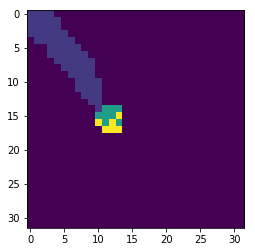

[[ 71.6036  123.9643  114.8107 ]
 [ 65.974   100.      121.0292 ]
 [124.2213  131.8328  100.     ]
 [ 86.9184  127.1449  126.3064 ]
 [ 92.15666 131.8851  122.8434 ]
 [ 79.3006  131.5593  113.2493 ]]


In [8]:
vol_training = np.array(dataset_vol[0:int(0.8*len(dataset_vol))])
vol_test = np.array(dataset_vol[int(0.8*len(dataset_vol)):])

lbl_training = np.array(dataset_lbl[0:int(0.8*len(dataset_lbl))])
lbl_test = np.array(dataset_lbl[int(0.8*len(dataset_lbl)):])

print("Training images size: \n",vol_training.shape)
print("Test images size: \n",vol_test.shape)

print("Training labels size: \n",lbl_training.shape)
print("Test labels size: \n",lbl_test.shape)

indice = 1000
slide = 0
vol_slide = np.reshape(vol_training[indice],(32,32,32))
vol_slide = vol_slide[:][:][slide]

plt.imshow(vol_slide)
plt.show()

print(lbl_training[0:6])


In [9]:
def voxnet(x, n_classes = 3 ):
    mu = 0
    sigma = 0.1
    #limpiar graficas anteriores
    #reset_graph()
    
    #Imagenes 
    img = tf.reshape(x, shape=[-1, 32,32,32,1])
    #tf.summary.image("Image", img)
    # Declarando las variables 
    
    weights = {'W_conv1':tf.Variable(tf.truncated_normal([5,5,5,1,32], mean = mu, stddev = sigma)),
               'W_conv2':tf.Variable(tf.truncated_normal([3,3,3,32,32], mean = mu, stddev = sigma)),
               'W_conv3':tf.Variable(tf.truncated_normal([3,3,3,12,8], mean = mu, stddev = sigma)),
               'W_fc1':tf.Variable(tf.truncated_normal([8*8*8*32,128], mean = mu, stddev = sigma)),
               'W_fc2':tf.Variable(tf.truncated_normal([1500, 500], mean = mu, stddev = sigma)),
               'W_fc3':tf.Variable(tf.truncated_normal([500, 100], mean = mu, stddev = sigma)),
               'W_fc4':tf.Variable(tf.truncated_normal([100,50], mean= mu, stddev= sigma)),
               'out':tf.Variable(tf.truncated_normal([128, n_classes], mean = mu, stddev = sigma))}
    """
    
    weights = {'W_conv1':tf.Variable(tf.random_normal([5,5,5,1,32])),
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,32])),
               'W_conv3':tf.Variable(tf.random_normal([3,3,3,12,8])),
               'W_fc1':tf.Variable(tf.random_normal([8*8*8*32,128])),
               'W_fc2':tf.Variable(tf.random_normal([1500, 500])),
               'W_fc3':tf.Variable(tf.random_normal([500, 100])),
               'W_fc4':tf.Variable(tf.random_normal([100,50])),
               'out':tf.Variable(tf.random_normal([128, n_classes]))}
    """

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
              'b_conv2':tf.Variable(tf.random_normal([32])),
              'b_conv3':tf.Variable(tf.random_normal([8])),
              'b_fc1':tf.Variable(tf.random_normal([128])),
              'b_fc2':tf.Variable(tf.random_normal([500])),
              'b_fc3':tf.Variable(tf.random_normal([100])),
              'b_fc4':tf.Variable(tf.random_normal([50])),
              'out':tf.Variable(tf.random_normal([n_classes]))}
   
    
    
    # Declarando la arquitectura
    
    #Input: 200x200x3     Output: 50x50x3
    l1 = tf.nn.conv3d(img, weights['W_conv1'], strides=[1,2,2,2,1], padding='SAME')
    l1 = tf.add(l1, biases['b_conv1'])
    l1 = tf.nn.relu(l1)
    #l1 = tf.nn.leaky_relu(l1)
    print("l1: ",l1.shape)
    #l1 = tf.nn.dropout(l1, keep_rate)
    #l1 = tf.nn.max_pool3d(l1, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='VALID')
    
    #Input: 50x50x3     Output: 50x50x6
    l2 = tf.nn.conv3d(l1, weights['W_conv2'], strides=[1,1,1,1,1], padding='SAME')
    l2 = tf.add(l2, biases['b_conv2'])
    l2 = tf.nn.relu(l2)
    #l2 = tf.nn.leaky_relu(l2)
    #l2 = tf.nn.dropout(l2, keep_rate)
    #print(l2)
    
    #Input: 50x50x6     Output: 25x25x6
    l2 = tf.nn.max_pool3d(l2, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='VALID')
    print("l2: ",l2.shape)
    
    #l3 = tf.nn.conv3d(l2, weights['W_conv3'], strides=[1,1,1,1,1], padding='SAME')
    #l3= tf.add(l3, biases['b_conv3'])
    #l3 = tf.nn.relu(l3)
    #l2 = tf.nn.dropout(l2, keep_rate2)
    #print(l2)
    
    #Input: 50x50x6     Output: 25x25x6
    #l3 = tf.nn.max_pool3d(l3, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='VALID')
    #print(l3.shape)
    
    
    #Input: 6x6x8     Output: 128
    fc1 = tf.reshape(l2, [-1, 8*8*8*32])
    fc1 = tf.nn.relu(tf.matmul(fc1, weights['W_fc1'])+biases['b_fc1'])
    #fc1 = tf.nn.leaky_relu(tf.matmul(fc1, weights['W_fc1'])+biases['b_fc1'])
    fc1 = tf.nn.dropout(fc1, keep_rate)
                          
    #Input: 128     Output: 64
    #fc2 = tf.nn.relu(tf.matmul(fc1, weights['W_fc2'])+biases['b_fc2'])
    #fc2 = tf.nn.dropout(fc2, keep_rate)
    
    #fc3 = tf.nn.relu(tf.matmul(fc2, weights['W_fc3'])+biases['b_fc3'])
    #fc3 = tf.nn.dropout(fc3, keep_rate)
    
    #fc4 = tf.nn.relu(tf.matmul(fc3, weights['W_fc4'])+biases['b_fc4'])
    #fc4 = tf.nn.dropout(fc4, keep_rate)

    output_ = tf.matmul(fc1, weights['out'])+biases['out']

    # Declarando la funcion de costo y entrenamiento
    #cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y) )
    #optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    #almacenar costo
    #tf.summary.scalar("costo", cost)
    #generar logs
    #summaries = tf.summary.merge_all()
    
    return output_

In [10]:
# Declarando las entradas y salidas
x=tf.placeholder('float',[None,32*32*32])
y=tf.placeholder('float')
keep_rate = tf.placeholder(tf.float32)
learning_rate = tf.placeholder(tf.float32)
output = voxnet(x)#################################

cost = tf.reduce_mean( tf.squared_difference(output, y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

#correct = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
#accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

l1:  (?, 16, 16, 16, 32)
l2:  (?, 8, 8, 8, 32)


In [11]:
def evaluate(x_data, y_data, eval_batch_size):
    sess = tf.get_default_session()
    eval_i = 0
    total_cost = 0
    count = 0
    for _ in range(int(len(x_data)/eval_batch_size)):
        eval_x = x_data[eval_i:eval_i + eval_batch_size]
        eval_y = y_data[eval_i:eval_i + eval_batch_size]
        eval_cost = sess.run(cost, feed_dict = {x:eval_x, y:eval_y, keep_rate: 1, learning_rate: 0.0005})
        total_cost += eval_cost
        eval_i = eval_i + eval_batch_size
        count = count  + 1
    total_cost = total_cost / count 
    return total_cost

In [12]:
def predicted_output(x_data, y_data, k_rate = 1):
    sess = tf.get_default_session()
    y_predicted = []
    for i in range(len(x_data)):
        val = sess.run(output, feed_dict={x: x_data[i:i+1], y:y_data[i:i+1], keep_rate: k_rate, learning_rate: 0.0005})
        y_predicted.append(val)
    return y_predicted

In [13]:
def test_neural_network():
    saver = tf.train.Saver()
    with tf.Session() as sess:
        model_path = 'esc100_pos_relu/SVEoctree_reg/450.ckpt'
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, model_path)
        final_train_predicted = predicted_output(vol_training, lbl_training, 1)
        final_test_predicted = predicted_output(vol_test, lbl_test, 1)
        return final_train_predicted, final_test_predicted

In [14]:
train_pred, test_pred = test_neural_network()

INFO:tensorflow:Restoring parameters from esc100_pos_relu/SVEoctree_reg/450.ckpt


In [15]:
### Variables Definition ###

####### Predicted ############
train_pred = np.array(train_pred)
test_pred = np.array(test_pred)

x_train_pred = train_pred[:,0][:,0]
y_train_pred = train_pred[:,0][:,1]
z_train_pred = train_pred[:,0][:,2]

x_test_pred = test_pred[:,0][:,0]
y_test_pred = test_pred[:,0][:,1]
z_test_pred = test_pred[:,0][:,2]

####### True ################
x_train_true = lbl_training[:,0]
y_train_true = lbl_training[:,1]
z_train_true = lbl_training[:,2]

x_test_true = lbl_test[:,0]
y_test_true = lbl_test[:,1]
z_test_true = lbl_test[:,2]
print(x_test_true)


[126.6019  64.4322  84.7303 ...  77.8933 135.1847  84.8593]


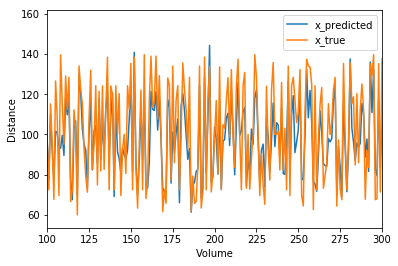

In [18]:
#%matplotlib notebook
inf = 100
sup = 300
##### Plot x train######
fig = plt.figure()
fig, ax = plt.subplots()
x_axe = np.arange(0,len(x_train_pred),1)
#ax = fig.add_axes([1,1,1,1])
ax.set_xlabel('Volume')
ax.set_ylabel('Distance')
ax.plot(x_axe, x_train_pred, label = 'x_predicted')
ax.plot(x_axe, x_train_true, label = 'x_true')
ax.set_xlim(left=inf, right=sup)
#fig.show()
#fig.savefig("x_test_function_esc100_relu.png", dpi = 300)
ax.legend()


(100, 300)

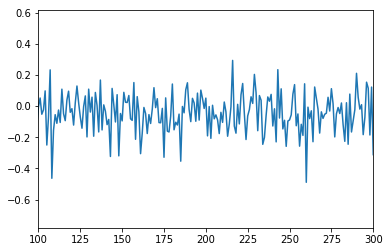

In [19]:
#error_function = ((x_test_pred - x_test_true)/100)-1
error_function = ((x_train_pred/100)-1) - ((x_train_true/100)-1)
x_axe_error = np.arange(0,len(error_function),1)
fig = plt.figure()
fig, ax = plt.subplots()
ax.plot(x_axe_error, error_function)
ax.set_xlim(left = inf, right=sup)
#fig.show()
#fig.savefig("error_esc_100_relu.png", dpi = 300)